In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()  # Turn off interactive mode

import statsmodels.api as sm
import numpy as np
from collections import Counter
import ast
import sys
from Backtester import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
company = pd.read_parquet('data/company_overview_cleaned.parquet')
filters = pd.read_pickle('data/groupings/filters.pkl')
by_employee = pd.read_csv('data/groupings/by_employee.csv')
by_industry = pd.read_csv('data/groupings/by_industry.csv')
by_revenue = pd.read_csv('data/groupings/by_revenue.csv')

features_db = pd.read_pickle('data/DB@rating_numeric.pkl')

In [4]:
rolling_ratings = pd.read_csv('data/rolling_period_ratings_stats.csv')
rolling_ratings['reviewDateTime'] = pd.to_datetime(rolling_ratings['reviewDateTime'])

# Generate portfolios

In [5]:
def generate_market_portfolio(rolling_ratings, universe=None):
    if universe:
        universe=universe
    else:
        universe = rolling_ratings['ticker'].unique()
    filtered_df = rolling_ratings[rolling_ratings['ticker'].isin(universe)]
    market_portfolio = filtered_df[['reviewDateTime','1M_ret']].groupby('reviewDateTime').mean()['1M_ret'].reset_index()
    market_portfolio.set_index('reviewDateTime',inplace=True)
    return market_portfolio

In [6]:
def generate_quantile_portfolios(df, filter_per_month=15, universe=None, rebalance=3, metric='ratingOverall', start_date='2014-01-31', end_date='2022-12-31', percentile=0.2):
    date_range = pd.date_range(start=start_date, end=end_date, freq='M')
    i = 0
    low_portfolio = []
    mid_portfolio = []
    high_portfolio = []
    ret = []
    if universe is not None:
        df = df[df['ticker'].isin(universe)]

    for date in date_range:
        snapshot = df[df['reviewDateTime']==date]
        snapshot = snapshot[snapshot[f"{rebalance}_{metric}_count"]>rebalance*filter_per_month]
        if i==0:
            num_rows = int(len(snapshot) * percentile)
            high_portfolio = snapshot.nlargest(num_rows, f"{rebalance}_{metric}_mean")['ticker'].values
            low_portfolio = snapshot.nsmallest(num_rows, f"{rebalance}_{metric}_mean")['ticker'].values
            mid_portfolio = list(set(snapshot['ticker'].unique()) - set(snapshot.nsmallest(num_rows, f"{rebalance}_{metric}_mean")['ticker'].values) - set(snapshot.nlargest(num_rows, f"{rebalance}_{metric}_mean")['ticker'].values))
        
        ret.append({'date': date, 
                    'high': snapshot[snapshot['ticker'].isin(high_portfolio)]['1M_ret'].mean(),
                    'mid': snapshot[snapshot['ticker'].isin(mid_portfolio)]['1M_ret'].mean(),
                    'low': snapshot[snapshot['ticker'].isin(low_portfolio)]['1M_ret'].mean(),
                    })
                    # 'ratings': snapshot[snapshot['ticker'].isin(portfolio)][f"{rebalance}_{metric}_mean"].mean(),
                    # 'port': len(portfolio)})
        i = (i+1)%rebalance

    ret = pd.DataFrame(ret)
    ret.set_index('date',inplace=True)
    return ret

In [7]:
PF = generate_quantile_portfolios(rolling_ratings)
mkt = generate_market_portfolio(rolling_ratings, universe=None)

In [8]:
PF.tail()

,high,mid,low
date,,,
2022-08-31,0.904211,0.898089,0.878331
2022-09-30,1.106090,1.110995,1.114802
2022-10-31,1.060248,1.046601,1.051102
2022-11-30,0.945527,0.943489,0.902388
2022-12-31,0.982359,1.017650,0.969708


In [9]:
mkt.tail()

,1M_ret
reviewDateTime,
2022-08-31,0.895128
2022-09-30,1.089568
2022-10-31,1.031763
2022-11-30,0.944462
2022-12-31,1.009899


# Run Regression

In [38]:
def plot_regression_res(combined_res, rebalance='Quarterly', filter='No filter', period='14-22'):

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    colors = []
    for label in combined_res['experiment']:
        if label.endswith('_high'):
            colors.append('red')  # Assign red for '_high'
        elif label.endswith('_low'):
            colors.append('green')  # Assign green for '_low'
        else:
            colors.append('blue')  # Default color if needed

    axs[0].bar(x=combined_res['experiment'], height=combined_res['avg_ret'], color=colors)
    axs[0].set_xticklabels(combined_res['experiment'], rotation=90)
    axs[0].set_title(f"Average Return by Portfolio\n{rebalance} Rebalance,{period}")
    axs[0].set_ylabel('Average Return')

    # Plot 2: Alpha
    colors_alpha = []
    for label in combined_res['experiment']:
        if label.endswith('_high'):
            colors_alpha.append('red')  # Assign red for '_high'
        elif label.endswith('_low'):
            colors_alpha.append('green')  # Assign green for '_low'
        else:
            colors_alpha.append('blue')  # Default color if needed

    axs[1].bar(x=combined_res['experiment'], height=combined_res['alpha'], color=colors_alpha)
    axs[1].set_xticklabels(combined_res['experiment'], rotation=90)
    axs[1].set_title(f"Alpha by Portfolio\n{rebalance} Rebalance,{period}")
    axs[1].set_ylabel('Alpha')

    # Adjust layout
    plt.tight_layout()
    plt.show()


def OLS_regression(rolling_ratings, metric, filter_per_month=15, rebalance=3, universe=None, start_date='2014-01-31', end_date='2019-12-31', percentile=0.2, tags=None):

    PF = generate_quantile_portfolios(rolling_ratings, filter_per_month=filter_per_month, rebalance=rebalance, metric=metric, start_date=start_date, end_date=end_date, universe=universe,
                                     percentile=percentile)
    mkt = generate_market_portfolio(rolling_ratings, universe=universe)
    PF = PF.loc[start_date:end_date,:]
    mkt = mkt.loc[start_date:end_date,:]

    results_list = []
    res = []

    for n in range(len(PF.columns)):        
        pf = PF.iloc[:,n]
        model = sm.OLS(pf.values, sm.add_constant(mkt.values))
        results = model.fit()

        if metric[:6]=='rating':
            metric = metric[6:]
            
        pf_res = {
            'experiment': f"{metric}_{PF.columns[n]}", # _{start_date.split('-')[0][2:4]}-{end_date.split('-')[0][2:4]}_{tags}
            'avg_ret': round(pf.mean()-1,4),
            'alpha': round(results.params[0],4),
            # 'beta': results.params[1],
            't_stat': round(results.tvalues[1],4),
            'pval': results.pvalues[1],
        }
        res.append(pf_res)

    return pd.DataFrame(res)

## Run Regression on all ratings

In [33]:
combined_res.set_index('experiment', inplace=True, drop=True, )

In [34]:
combined_res

,avg_ret,alpha,t_stat,pval
experiment,,,,
Overall_high,0.013508,0.193004,20.053444,7.279081e-38
Overall_mid,0.010631,0.138605,29.941964,1.567858e-53
Overall_low,0.010904,-0.087362,17.648218,2.507014e-33
CompensationAndBenefits_high,0.012748,0.240626,19.817581,1.963850e-37
CompensationAndBenefits_mid,0.011187,0.151188,26.340719,2.516267e-48
CompensationAndBenefits_low,0.010975,-0.116527,12.915859,1.707576e-23
SeniorLeadership_high,0.013059,0.179372,20.793074,3.385287e-39
SeniorLeadership_mid,0.011176,0.143982,28.110553,6.007954e-51
SeniorLeadership_low,0.010165,-0.028614,15.772262,1.438931e-29


In [47]:
features = ['ratingOverall', 'ratingCompensationAndBenefits', 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
        'ratingCareerOpportunities', 'ratingCultureAndValues']

# universe = list(
#                 set(filters['on_glassdoor_before_2013']) 
#                 & set(filters['mcap>e9']) 
#                 - set(filters['extreme_stocks']))

combined_res = pd.DataFrame()
for i in features:
    res = OLS_regression(rolling_ratings, i,rebalance=3, universe=None, start_date='2014-01-31', end_date='2022-12-31')
    combined_res = pd.concat([combined_res, res],axis=0)

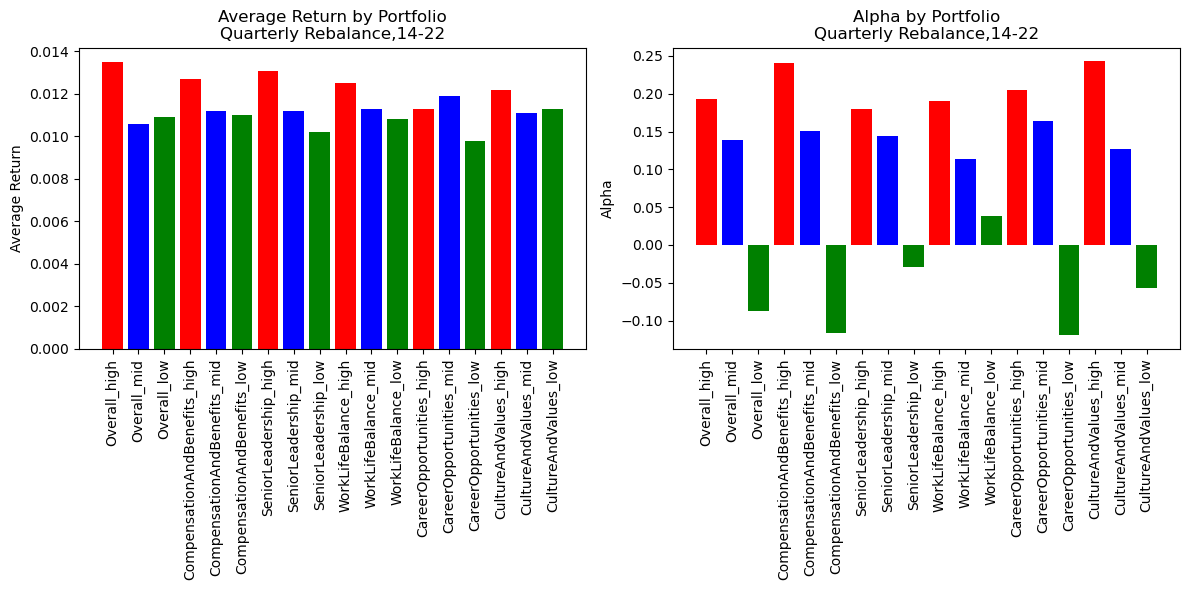

In [48]:
plot_regression_res(combined_res)

In [39]:
features = ['ratingOverall', 'ratingCompensationAndBenefits', 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
        'ratingCareerOpportunities', 'ratingCultureAndValues']

universe = list(
                set(filters['on_glassdoor_before_2013']) 
                & set(filters['mcap>e9']) 
                - set(filters['extreme_stocks']))

combined_res = pd.DataFrame()
for i in features:
    res = OLS_regression(rolling_ratings, i,rebalance=1, universe=universe, start_date='2014-01-31', end_date='2022-12-31', percentile=0.2, filter_per_month=5)
    combined_res = pd.concat([combined_res, res],axis=0)

In [40]:
combined_res

,experiment,avg_ret,alpha,t_stat,pval
0,Overall_high,0.0124,0.0858,32.6696,3.723456e-57
1,Overall_mid,0.0111,0.0347,65.0668,2.814658e-87
2,Overall_low,0.0100,-0.0762,46.3563,3.341488e-72
0,CompensationAndBenefits_high,0.0134,0.1255,30.1911,7.137966e-54
1,CompensationAndBenefits_mid,0.0111,0.0213,67.6142,5.281466e-89
2,CompensationAndBenefits_low,0.0088,-0.0478,37.4944,5.386449e-63
0,SeniorLeadership_high,0.0134,0.0936,30.2560,5.819507e-54
1,SeniorLeadership_mid,0.0110,0.0381,57.9058,4.689963e-82
2,SeniorLeadership_low,0.0093,-0.0632,44.0778,5.379289e-70
0,WorkLifeBalance_high,0.0122,0.0715,32.9774,1.505142e-57


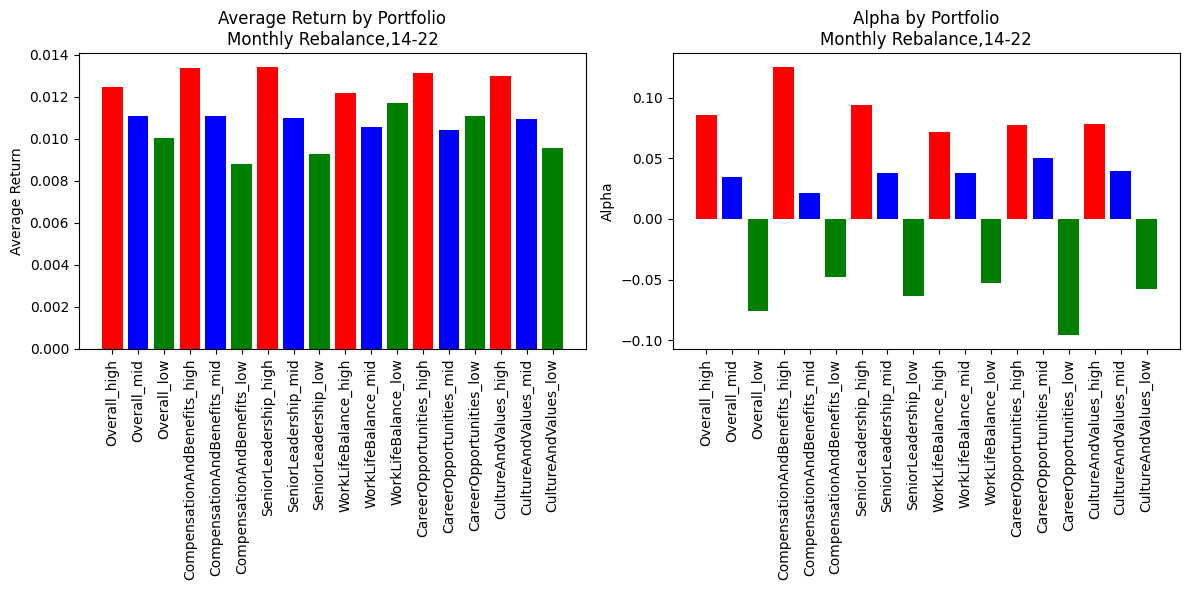

In [73]:
plot_regression_res(combined_res, rebalance='Monthly', filter='>5 reviews per month')

## Run Regression on Unemployed ratings

In [41]:
unemployed_rolling_ratings = pd.read_csv('data/not_employed_OLS.csv')
unemployed_rolling_ratings['reviewDateTime'] = pd.to_datetime(unemployed_rolling_ratings['reviewDateTime'])

In [42]:
features = ['ratingOverall', 'ratingCompensationAndBenefits', 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
        'ratingCareerOpportunities', 'ratingCultureAndValues']

# universe = list(
#                 set(filters['on_glassdoor_before_2013']) 
#                 & set(filters['mcap>e9']) 
#                 - set(filters['extreme_stocks']))

combined_res = pd.DataFrame()
for i in features:
    res = OLS_regression(unemployed_rolling_ratings, i,rebalance=1, universe=None, start_date='2014-01-31', end_date='2022-12-31', filter_per_month=5)
    combined_res = pd.concat([combined_res, res],axis=0)

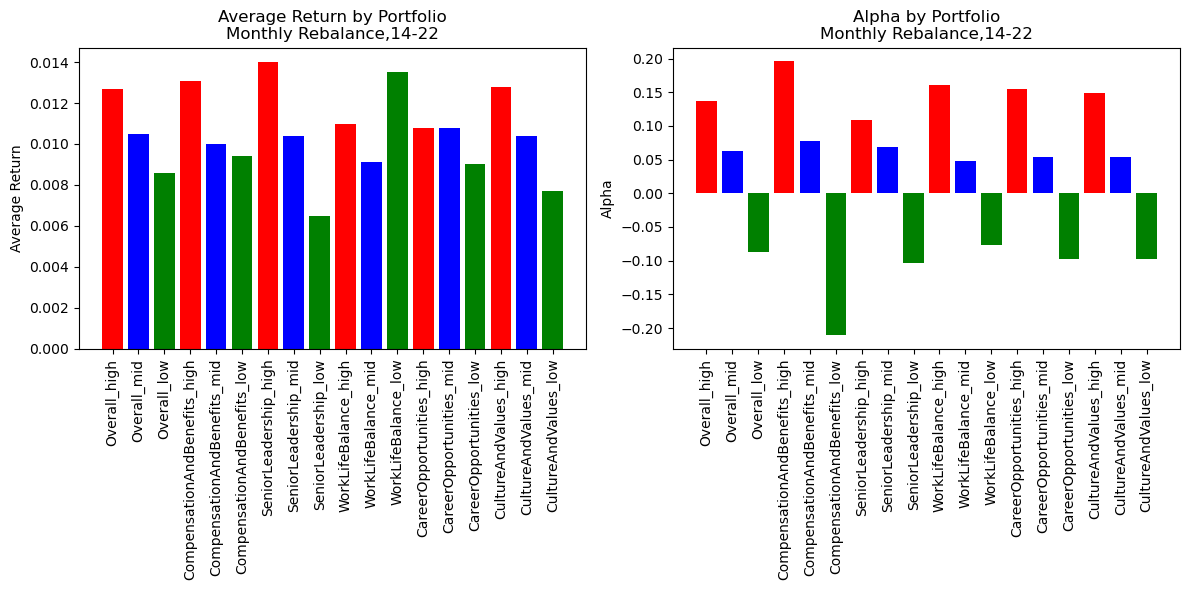

In [43]:
plot_regression_res(combined_res, 'Monthly')

In [44]:
combined_res

,experiment,avg_ret,alpha,t_stat,pval
0,Overall_high,0.0127,0.1365,19.8590,1.649093e-37
1,Overall_mid,0.0105,0.0628,25.4593,5.697959e-47
2,Overall_low,0.0086,-0.0872,22.3966,5.473034e-42
0,CompensationAndBenefits_high,0.0131,0.1957,19.2139,2.569988e-36
1,CompensationAndBenefits_mid,0.0100,0.0776,28.3569,2.653227e-51
2,CompensationAndBenefits_low,0.0094,-0.2105,16.0795,3.383517e-30
0,SeniorLeadership_high,0.0140,0.1087,19.6238,4.461299e-37
1,SeniorLeadership_mid,0.0104,0.0694,26.5970,1.030634e-48
2,SeniorLeadership_low,0.0065,-0.1035,21.3689,3.251994e-40
0,WorkLifeBalance_high,0.0110,0.1603,18.0979,3.363410e-34


## Run Regression on NLP data

In [11]:
nlp_rolling_ratings = pd.read_csv('data/nlp_rollingret.csv')
nlp_rolling_ratings['reviewDateTime'] = pd.to_datetime(nlp_rolling_ratings['reviewDateTime'])

In [12]:
periods = [1,3,6,9,12,24]
features = [i[2:-5] for i in nlp_rolling_ratings.filter(like='1_').filter(like='_mean').columns]

for i in features:
    for t in periods:
        nlp_rolling_ratings[f"{t}_{i}_count"] = nlp_rolling_ratings[f"{t}_{i}_negcount"] + nlp_rolling_ratings[f"{t}_{i}_poscount"]

In [13]:
features = [i[2:-5] for i in nlp_rolling_ratings.filter(like='1_').filter(like='_mean').columns]

# universe = list(
#                 set(filters['on_glassdoor_before_2013']) 
#                 & set(filters['mcap>e9']) 
#                 - set(filters['extreme_stocks']))

combined_res = pd.DataFrame()
for i in features:
    res = OLS_regression(nlp_rolling_ratings, i,filter_per_month=5, rebalance=1, universe=None, start_date='2014-01-31', end_date='2022-12-31')
    combined_res = pd.concat([combined_res, res],axis=0)

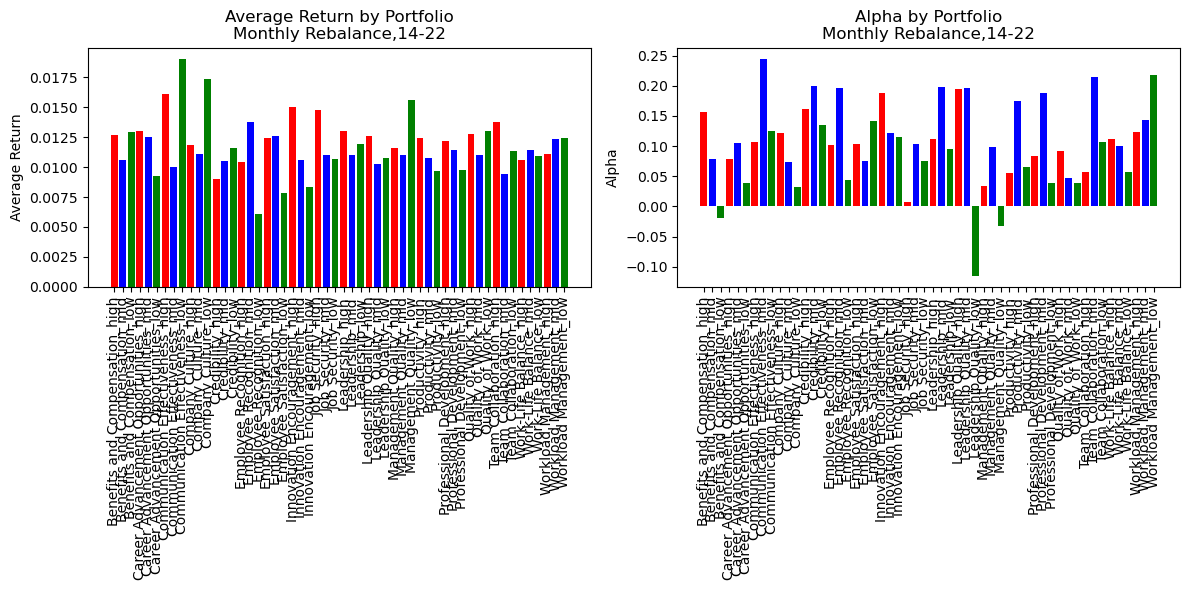

In [14]:
plot_regression_res(combined_res, 'Monthly')

In [63]:
def generate_quantile_portfolios_diff(df, short=6, long=12, filter_per_month=15, universe=None, rebalance=3, metric='ratingOverall', start_date='2014-01-31', end_date='2022-12-31', percentile=0.2):
    date_range = pd.date_range(start=start_date, end=end_date, freq='M')
    i = 0
    low_portfolio = []
    mid_portfolio = []
    high_portfolio = []
    ret = []
    if universe is not None:
        df = df[df['ticker'].isin(universe)]

    for date in date_range:
        snapshot = df[df['reviewDateTime']==date]
        snapshot['diff'] = snapshot[f'{long}_{metric}'] - snapshot[f'{short}_{metric}'] 
        # snapshot = snapshot[snapshot[f"{rebalance}_{metric}_count"]>rebalance*filter_per_month]
        if i==0:
            num_rows = int(len(snapshot) * percentile)
            high_portfolio = snapshot.nlargest(num_rows, "diff")['ticker'].values
            low_portfolio = snapshot.nsmallest(num_rows, "diff")['ticker'].values
            mid_portfolio = list(set(snapshot['ticker'].unique()) - set(snapshot.nsmallest(num_rows, "diff")['ticker'].values) - set(snapshot.nlargest(num_rows, "diff")['ticker'].values))
        
        ret.append({'date': date, 
                    'high': snapshot[snapshot['ticker'].isin(high_portfolio)]['1M_ret'].mean(),
                    'mid': snapshot[snapshot['ticker'].isin(mid_portfolio)]['1M_ret'].mean(),
                    'low': snapshot[snapshot['ticker'].isin(low_portfolio)]['1M_ret'].mean(),
                    })
                    # 'ratings': snapshot[snapshot['ticker'].isin(portfolio)][f"{rebalance}_{metric}_mean"].mean(),
                    # 'port': len(portfolio)})
        i = (i+1)%rebalance

    ret = pd.DataFrame(ret)
    ret.set_index('date',inplace=True)
    return ret

In [52]:
def OLS_regression(rolling_ratings, metric, short=6, long=12, filter_per_month=15, rebalance=3, universe=None, start_date='2014-01-31', end_date='2019-12-31', percentile=0.2, tags=None):

    PF = generate_quantile_portfolios_diff(rolling_ratings, short=short, long=long, filter_per_month=filter_per_month, rebalance=rebalance, metric=metric, start_date=start_date, end_date=end_date, universe=universe,
                                     percentile=percentile)
    mkt = generate_market_portfolio(rolling_ratings, universe=universe)
    PF = PF.loc[start_date:end_date,:]
    mkt = mkt.loc[start_date:end_date,:]

    results_list = []
    res = []

    for n in range(len(PF.columns)):        
        pf = PF.iloc[:,n]
        model = sm.OLS(pf.values, sm.add_constant(mkt.values))
        results = model.fit()

        if metric[:6]=='rating':
            metric = metric[6:]
            
        pf_res = {
            'experiment': f"{metric}_{PF.columns[n]}", # _{start_date.split('-')[0][2:4]}-{end_date.split('-')[0][2:4]}_{tags}
            'avg_ret': round(pf.mean()-1,4),
            'alpha': round(results.params[0],4),
            # 'beta': results.params[1],
            't_stat': round(results.tvalues[1],4),
            'pval': results.pvalues[1],
        }
        res.append(pf_res)

    return pd.DataFrame(res)

In [64]:
features = [i[2:] for i in nlp_rolling_ratings.filter(like='1_').filter(like='_negcount').columns]

combined_res = pd.DataFrame()
for i in features:
    res = OLS_regression(nlp_rolling_ratings, i, filter_per_month=5, rebalance=3, universe=None, start_date='2014-01-31', end_date='2022-12-31')
    combined_res = pd.concat([combined_res, res],axis=0)

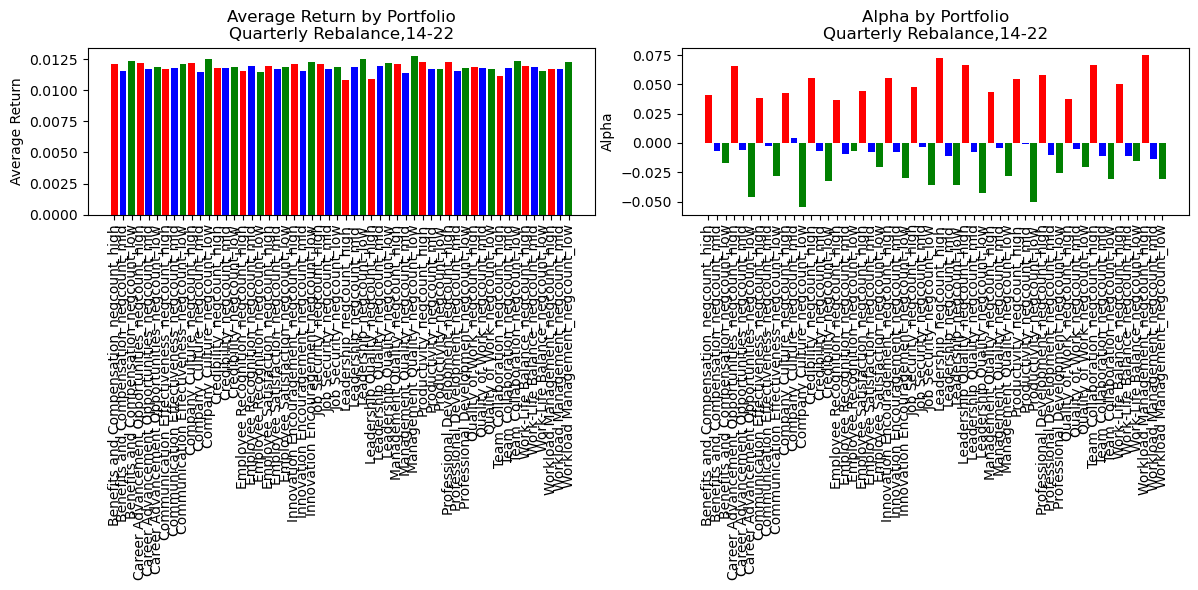

In [65]:
plot_regression_res(combined_res, 'Quarterly')

In [86]:
features = [i[2:] for i in nlp_rolling_ratings.filter(like='1_').filter(like='_negcount').columns]

combined_res = pd.DataFrame()
for i in features:
    res = OLS_regression(nlp_rolling_ratings, i, filter_per_month=5, rebalance=1, universe=None, start_date='2014-01-31', end_date='2022-12-31')
    combined_res = pd.concat([combined_res, res],axis=0)

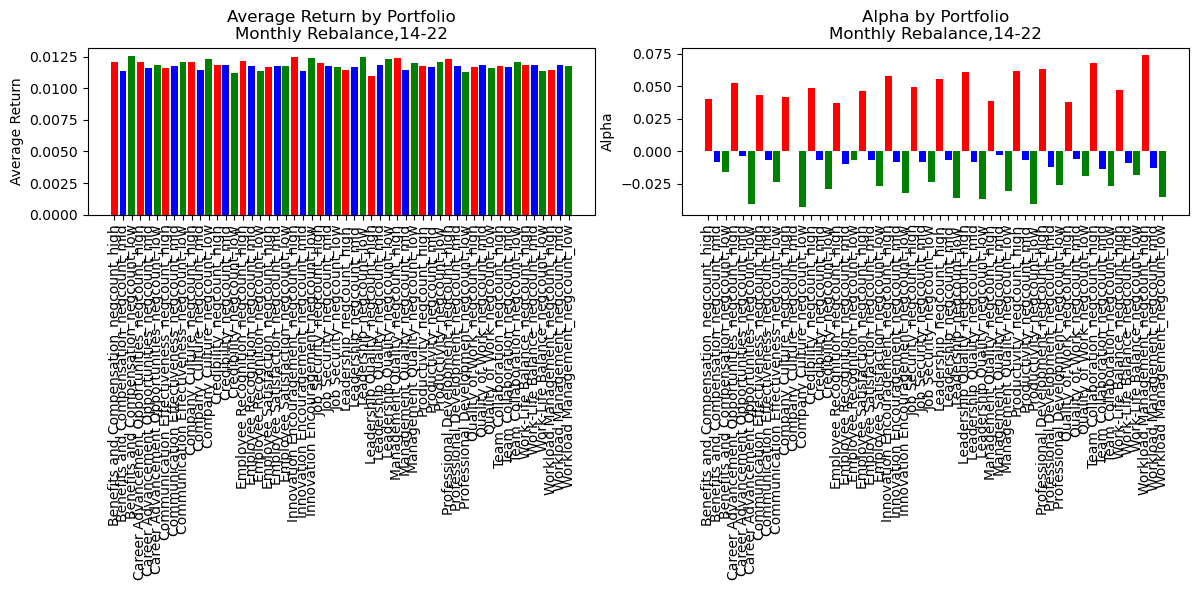

In [87]:
plot_regression_res(combined_res, 'Monthly')

In [88]:
combined_res

,experiment,avg_ret,alpha,t_stat,pval
0,Benefits and Compensation_negcount_high,0.0121,0.0400,41.2393,4.242982e-67
1,Benefits and Compensation_negcount_mid,0.0114,-0.0081,156.5434,3.160447e-127
2,Benefits and Compensation_negcount_low,0.0126,-0.0157,61.6984,6.825177e-85
0,Career Advancement Opportunities_negcount_high,0.0121,0.0525,42.9349,7.525823e-69
1,Career Advancement Opportunities_negcount_mid,0.0116,-0.0039,163.7380,2.752039e-129
2,Career Advancement Opportunities_negcount_low,0.0119,-0.0407,70.5537,6.395675e-91
0,Communication Effectiveness_negcount_high,0.0116,0.0435,49.5655,3.776602e-75
1,Communication Effectiveness_negcount_mid,0.0118,-0.0067,153.3633,2.757038e-126
2,Communication Effectiveness_negcount_low,0.0121,-0.0234,81.3324,2.393355e-97
0,Company Culture_negcount_high,0.0121,0.0415,39.3788,4.205249e-65


In [70]:
features = [i[2:] for i in nlp_rolling_ratings.filter(like='1_').filter(like='_poscount').columns]

combined_res = pd.DataFrame()
for i in features:
    res = OLS_regression(nlp_rolling_ratings, i, filter_per_month=5, rebalance=3, universe=None, start_date='2014-01-31', end_date='2022-12-31')
    combined_res = pd.concat([combined_res, res],axis=0)

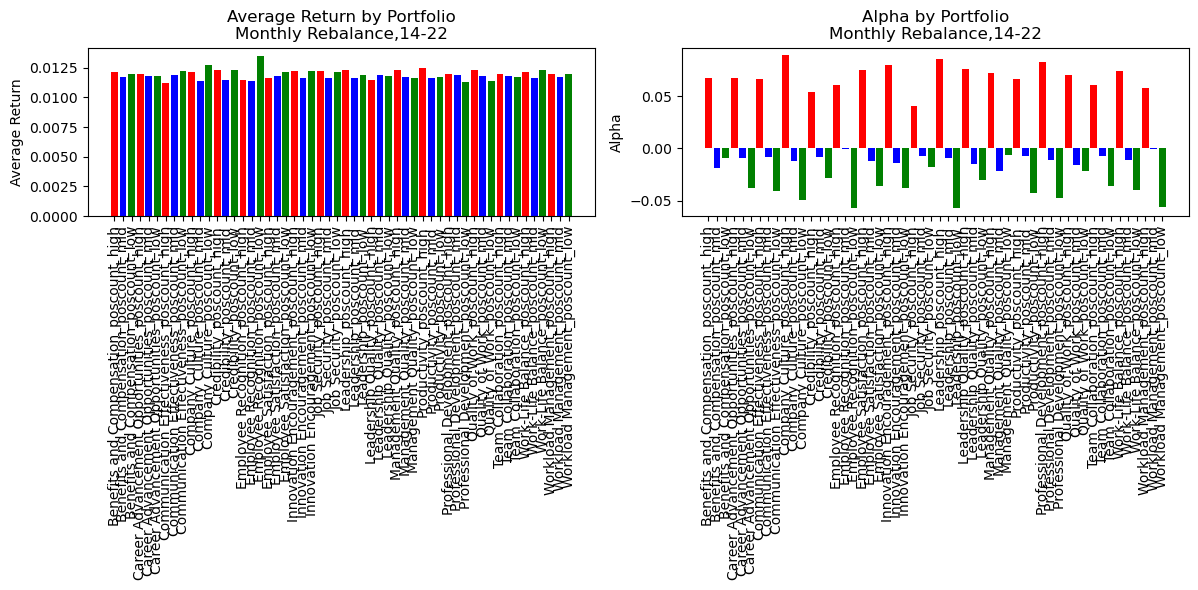

In [71]:
plot_regression_res(combined_res, 'Monthly')

In [74]:
features = [i[2:] for i in nlp_rolling_ratings.filter(like='1_').filter(like='_mean').columns]

combined_res = pd.DataFrame()
for i in features:
    res = OLS_regression(nlp_rolling_ratings, i, filter_per_month=5, rebalance=3, universe=None, start_date='2014-01-31', end_date='2022-12-31')
    combined_res = pd.concat([combined_res, res],axis=0)

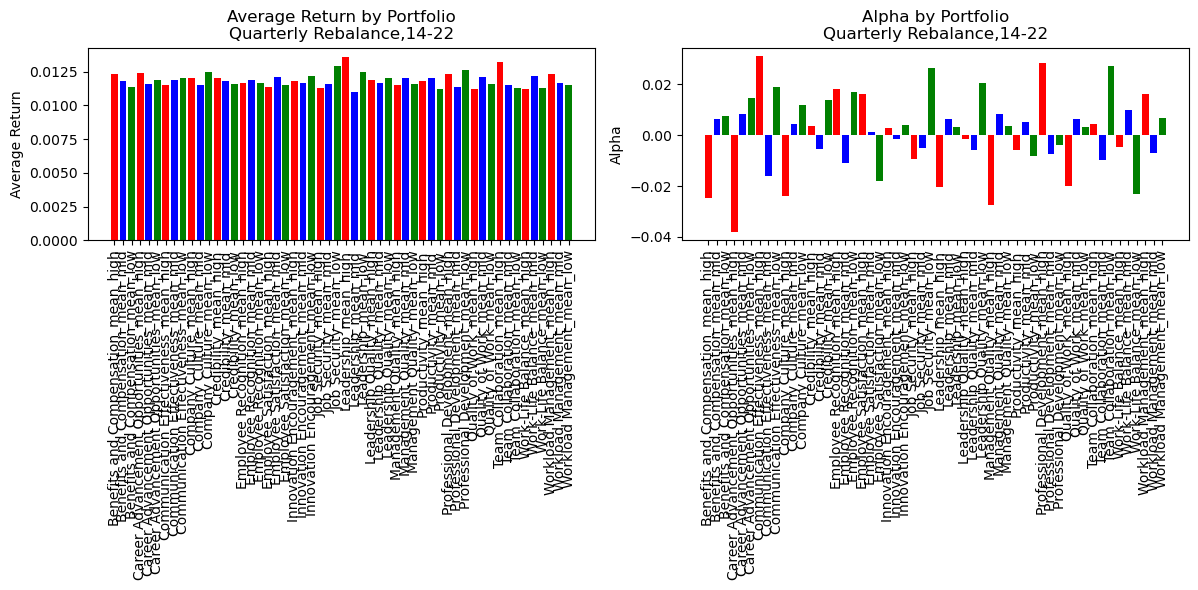

In [75]:
plot_regression_res(combined_res, 'Quarterly')

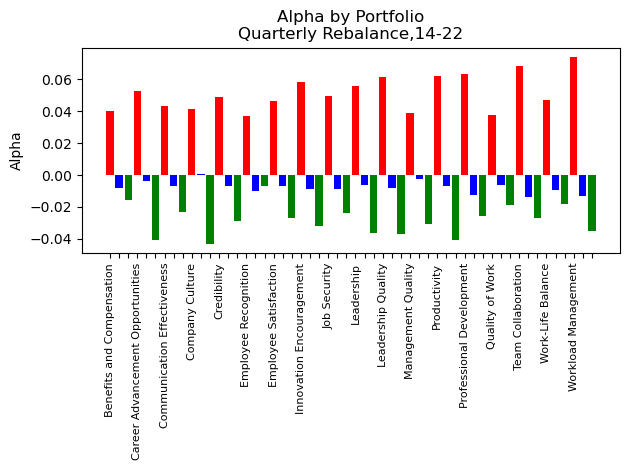

In [85]:
colors_alpha = []
for label in combined_res['experiment']:
    if label.endswith('_high'):
        colors_alpha.append('red')  
    elif label.endswith('_low'):
        colors_alpha.append('green')  # Assign green for '_low'
    else:
        colors_alpha.append('blue')  # Default color if needed

xlabels = [i.split('_')[0] if i[-4:]=='high' else ' ' for i in combined_res['experiment']]
plt.bar(x=combined_res['experiment'], height=combined_res['alpha'], color=colors_alpha)
plt.xticks(ticks=range(len(xlabels)), labels=xlabels, rotation=90, fontsize=8)
plt.title(f"Alpha by Portfolio\nQuarterly Rebalance,14-22")
plt.ylabel('Alpha')

# Adjust layout
plt.tight_layout()
plt.show()